In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import time

# Read in the Bitcoin data

In [2]:
bitcoindf = pd.read_csv("dfbitcoin.csv")

# Transform the data
## Get the next day change %

In [3]:
bitcoindf["Change %"] = bitcoindf["Change %"].str.rstrip('%').astype('float') / 100.0

In [4]:
bitcoindf["NextDayChange"] = bitcoindf["Change %"].shift(-1)

In [5]:
bitcoindf = bitcoindf.dropna()

## Categorize the data base on what the change was

In [6]:
conditions = [
               (bitcoindf["NextDayChange"] <= -0.025), 
               (bitcoindf["NextDayChange"] > -0.025) & (bitcoindf["NextDayChange"] < 0.025),
               (bitcoindf["NextDayChange"] >= 0.025)
             ]
values = [0, 1, 2]
bitcoindf['ChangeGroup'] = np.select(conditions, values)

## Trim it down to just the columns we are interested in

In [7]:
bitcoindf = bitcoindf[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc", "ChangeGroup"]].copy()

In [8]:
bitcoindf.describe()

,CommentCount,PremiumCount,Controversiality,FollowCount,Score,PositivePerc,NegativePerc,ChangeGroup
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,8664.140940,389.275168,174.134228,5990.127517,3.654199,0.233842,0.299085,1.053691
std,3248.810023,130.416944,80.273490,2316.985044,0.501808,0.038705,0.040959,0.705052
min,4598.000000,186.000000,64.000000,2626.000000,2.762252,0.139394,0.200000,0.000000
25%,6440.000000,290.000000,121.000000,4463.000000,3.319198,0.206061,0.278788,1.000000
50%,8129.000000,371.000000,157.000000,5461.000000,3.610241,0.230303,0.296970,1.000000
75%,9837.000000,446.000000,203.000000,6831.000000,3.924452,0.260606,0.321212,2.000000
max,27282.000000,931.000000,600.000000,19345.000000,5.507202,0.321212,0.418182,2.000000


## Scale the data

In [9]:
bitcoindf["CommentCount"] = bitcoindf["CommentCount"] / 35000

In [10]:
bitcoindf["PremiumCount"] = bitcoindf["PremiumCount"] / 1000

In [11]:
bitcoindf["FollowCount"] = bitcoindf["FollowCount"] / 25000

In [12]:
bitcoindf["Score"] = bitcoindf["Score"] / 6

# Create train, test, and validation data sets

In [13]:
bitcoin_train, bitcoin_test = train_test_split(bitcoindf, test_size=0.4)

In [14]:
bitcoin_test, bitcoin_valid = train_test_split(bitcoin_test, test_size=0.5)

In [15]:
X_train = bitcoin_train[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [16]:
y_train = bitcoin_train[["ChangeGroup"]].to_numpy()

In [17]:
X_test = bitcoin_test[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [18]:
y_test = bitcoin_test[["ChangeGroup"]].to_numpy()

In [19]:
X_valid = bitcoin_valid[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [20]:
y_valid = bitcoin_valid[["ChangeGroup"]].to_numpy()

In [21]:
bitcoin_train[["ChangeGroup"]].describe()

,ChangeGroup
count,89.000000
mean,1.067416
std,0.687515
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [22]:
bitcoin_train[bitcoin_train["ChangeGroup"] == 1][["ChangeGroup"]].describe()

,ChangeGroup
count,47.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


# Build neural network model

In [23]:
root_logdir = os.path.join(os.curdir, "tensor_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[7,]))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [27]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb])

Epoch 1/60
3/3 [==============================] - 1s 287ms/step - loss: 22.8428 - accuracy: 0.3820 - val_loss: 1.0981 - val_accuracy: 0.3333
Epoch 2/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0976 - accuracy: 0.4045 - val_loss: 1.0976 - val_accuracy: 0.4000
Epoch 3/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0959 - accuracy: 0.5281 - val_loss: 1.0971 - val_accuracy: 0.4000
Epoch 4/60
3/3 [==============================] - 0s 13ms/step - loss: 1.0942 - accuracy: 0.5281 - val_loss: 1.0966 - val_accuracy: 0.4000
Epoch 5/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0924 - accuracy: 0.5281 - val_loss: 1.0962 - val_accuracy: 0.4000
Epoch 6/60
3/3 [==============================] - 0s 13ms/step - loss: 1.0908 - accuracy: 0.5281 - val_loss: 1.0958 - val_accuracy: 0.4000
Epoch 7/60
3/3 [==============================] - 0s 13ms/step - loss: 1.0892 - accuracy: 0.5281 - val_loss: 1.0954 - val_accuracy: 0.4000
Epoch 8/60
3/3 [=========

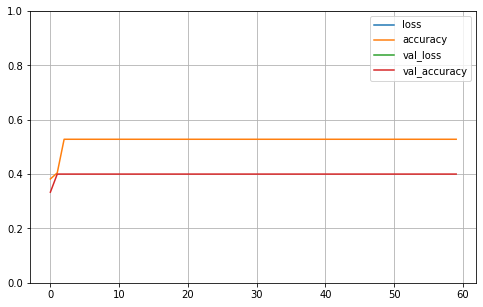

In [28]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [27]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 1.0439 - accuracy: 0.5135


[1.0438989400863647, 0.5135135054588318]

In [28]:
y_proba = model.predict(X_test)
y_proba.round(2)

array([[0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.31],
       [0.26, 0.42, 0.33],
       [0.26, 0.42, 0.32],
       [0.27, 0.43, 0.3 ],
       [0.26, 0.42, 0.32],
       [0.26, 0.43, 0.31],
       [0.26, 0.43, 0.31],
       [0.26, 0.41, 0.33],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.25, 0.41, 0.33],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.27, 0.43, 0.3 ],
       [0.26, 0.41, 0.33],
       [0.26, 0.42, 0.32],
       [0.27, 0.43, 0.31],
       [0.25, 0.41, 0.33],
       [0.26, 0.42, 0.31],
       [0.26, 0.42, 0.32],
       [0.25, 0.42, 0.33],
       [0.27, 0.43, 0.3 ],
       [0.25, 0.42, 0.33],
       [0.26, 0.42, 0.31],
       [0.29, 0.43, 0.28],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.33],
       [0.26, 0.42, 0.31],
       [0.26, 0.42, 0.32],
       [0.27, 0.43, 0.3 ],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
       [0.26, 0.42, 0.32],
 

In [219]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.3 , 0.38, 0.32],
       [0.29, 0.38, 0.33],
       [0.31, 0.37, 0.32]], dtype=float32)

In [220]:
y_test[:3]

array([[2],
       [1],
       [1]])

In [221]:
model2 = keras.models.Sequential()
model2.add(keras.layers.InputLayer(input_shape=[7,]))
model2.add(keras.layers.Dense(300, activation="relu"))
model2.add(keras.layers.Dense(600, activation="relu"))
model2.add(keras.layers.Dense(300, activation="relu"))
model2.add(keras.layers.Dense(100, activation="relu"))
model2.add(keras.layers.Dense(3, activation="softmax"))

In [222]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [223]:
history2 = model2.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
3/3 [==============================] - 0s 60ms/step - loss: 1.0997 - accuracy: 0.2809 - val_loss: 1.0945 - val_accuracy: 0.5467
Epoch 2/30
3/3 [==============================] - 0s 14ms/step - loss: 1.0931 - accuracy: 0.5281 - val_loss: 1.0879 - val_accuracy: 0.5467
Epoch 3/30
3/3 [==============================] - 0s 18ms/step - loss: 1.0869 - accuracy: 0.5281 - val_loss: 1.0821 - val_accuracy: 0.5467
Epoch 4/30
3/3 [==============================] - 0s 14ms/step - loss: 1.0815 - accuracy: 0.5281 - val_loss: 1.0769 - val_accuracy: 0.5467
Epoch 5/30
3/3 [==============================] - 0s 12ms/step - loss: 1.0771 - accuracy: 0.5281 - val_loss: 1.0717 - val_accuracy: 0.5467
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 1.0729 - accuracy: 0.5281 - val_loss: 1.0680 - val_accuracy: 0.5467
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 1.0688 - accuracy: 0.5281 - val_loss: 1.0641 - val_accuracy: 0.5467
Epoch 8/30
3/3 [===========

In [224]:
model2.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 1.0621 - accuracy: 0.4595


[1.0620810985565186, 0.45945945382118225]

In [225]:
X_new = X_test[:3]
y_proba = model2.predict(X_new)
y_proba.round(2)

array([[0.26, 0.44, 0.3 ],
       [0.25, 0.45, 0.3 ],
       [0.26, 0.44, 0.3 ]], dtype=float32)

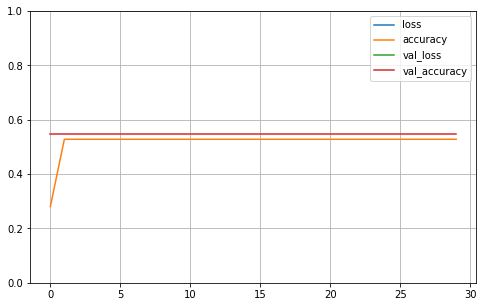

In [226]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()